Anggota Kelompok :
* Hasif Priyambudi		: 20.11.3305
* Dafa Dzikri Mawadin		: 20.11.3328
* Zaky Muhammad Wahyudi	: 20.11.3340
* Akmal Zulfikar Fadhillah	: 20.11.3323
* Akhmad Khosni Mubarak	: 20.11.3343



In [ ]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 10.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=8e6aa51fc1f39ecbf24b04ef3df410a0beb4e60bbb37980e9db3c02ff4f35a86
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Pyspark

In [ ]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, RegexTokenizer
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("Final Projek")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark
sc = spark.sparkContext

# Load Data

In [ ]:
df = spark.read.option("header", True).csv("data.csv")

In [ ]:
df.show(5)

+--------------------+---------+
|            Sentence|Sentiment|
+--------------------+---------+
|The GeoSolutions ...| positive|
|$ESI on lows, dow...| negative|
|For the last quar...| positive|
|According to the ...|  neutral|
|The Swedish buyou...|  neutral|
+--------------------+---------+
only showing top 5 rows



In [ ]:
df.count()

5842

# Pre-processing

In [ ]:
# Menghapus Data Kosong
df = df.dropna()

In [ ]:
# Menghapus Data Duplicate
df = df.dropDuplicates()

In [ ]:
# Melihat class y yang akan diprediksi
df.select("Sentiment").distinct().collect()

[Row(Sentiment='positive'),
 Row(Sentiment='neutral'),
 Row(Sentiment='negative'),
 Row(Sentiment=' the damage is done. No one wants to touch it now"')]

In [ ]:
# Menghapus class y yang memiliki data "the damage is done. No One wants to touch it now"
df = df.filter(df.Sentiment != ' the damage is done. No one wants to touch it now"')

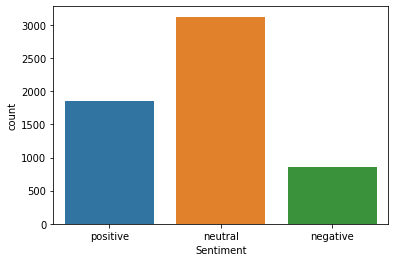

In [ ]:
# Meliihat Total Data
sentiment = df.select("Sentiment").toPandas()
sns.countplot(x='Sentiment', data=sentiment)

# Balancing Data

## Balancing Negative ke Neutral

In [ ]:
minority_class = df[df.Sentiment == "negative"]
majority_class = df[df.Sentiment == "neutral"]
sampling_minority_class = minority_class.sample(True, majority_class.count() / minority_class.count())

# Concatenate the two classes
balanced_df = majority_class.union(sampling_minority_class)

## Balancing Positive ke Neutral

In [ ]:
minority_class = df[df.Sentiment == "positive"]
majority_class = df[df.Sentiment == "neutral"]
sampling_minority_class = minority_class.sample(True, majority_class.count() / minority_class.count())

# Concatenate the two classes
df = balanced_df.union(sampling_minority_class)

## Persebaran Data

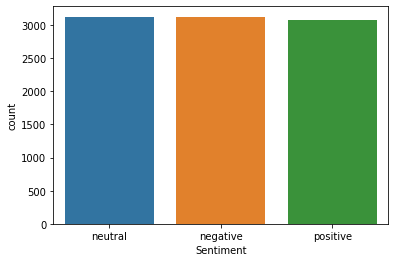

In [ ]:
# Meliihat Total Data
sentiment = df.select("Sentiment").toPandas()
sns.countplot(x='Sentiment', data=sentiment)

# Split Data train, test, val

In [ ]:
(train_set, val_set) = df.randomSplit([0.80, 0.20], seed = 2000)

# Modelling

## RegexTokenizer+CountVector+Logistic Regression

In [ ]:
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="Sentence", outputCol="words", pattern="\\W")
# bag of words count
countVectors = CountVectorizer(inputCol="words", outputCol="features", vocabSize=30000, minDF=5)
# Label String
label_stringIdx = StringIndexer(inputCol="Sentiment", outputCol = "label")
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
pipeline = Pipeline(stages=[regexTokenizer, countVectors, label_stringIdx, lr])

In [ ]:
pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)

## CountVectorizer + IDF + Logistic Regression

In [ ]:
tokenizer2 = Tokenizer(inputCol="Sentence", outputCol="words")
cv2 = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf2 = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx2 = StringIndexer(inputCol = "Sentiment", outputCol = "label")
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
pipeline2 = Pipeline(stages=[tokenizer2, cv2, idf2, label_stringIdx2, lr])

In [ ]:
pipelineFit2 = pipeline2.fit(train_set)
predictions2 = pipelineFit2.transform(val_set)

# Evaluasi

## RegexTokenizer+CountVector+Logistic Regression

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

In [ ]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

In [ ]:
print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.8312
ROC-AUC: 0.8299


## CountVectorizer + IDF + Logistic Regression

In [ ]:
evaluator2 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

In [ ]:
accuracy2 = predictions2.filter(predictions2.label == predictions2.prediction).count() / float(val_set.count())
roc_auc2 = evaluator2.evaluate(predictions2)

In [ ]:
print("Accuracy Score: {0:.4f}".format(accuracy2))
print("ROC-AUC: {0:.4f}".format(roc_auc2))

Accuracy Score: 0.8418
ROC-AUC: 0.8413


# Confusion Matrix

## RegexTokenizer+CountVector+Logistic Regression

In [ ]:
prediction_and_label_rdd = predictions.select("prediction", "label").rdd.map(lambda x: (x[0], x[1]))

# Create a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label_rdd)

# Print the confusion matrix
print(metrics.confusionMatrix())

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[438., 108.,  58.],
             [ 42., 569.,  15.],
             [ 66.,  29., 559.]])


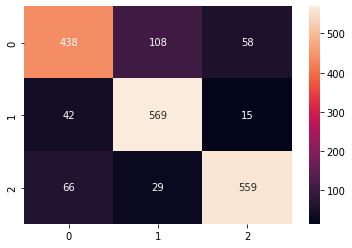

In [ ]:
prediksi = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
labels = predictions.select("label").rdd.flatMap(lambda x: x).collect()

# Create a confusion matrix
cm = confusion_matrix(labels, prediksi)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt=".0f")
plt.show()

In [ ]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76       604
         1.0       0.81      0.91      0.85       626
         2.0       0.88      0.85      0.87       654

    accuracy                           0.83      1884
   macro avg       0.83      0.83      0.83      1884
weighted avg       0.83      0.83      0.83      1884



## CountVectorizer + IDF + Logistic Regression

In [ ]:
prediction_and_label_rdd2 = predictions2.select("prediction", "label").rdd.map(lambda x: (x[0], x[1]))

# Create a MulticlassMetrics object
metrics2 = MulticlassMetrics(prediction_and_label_rdd2)

# Print the confusion matrix
print(metrics2.confusionMatrix())

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[458.,  99.,  47.],
             [ 49., 561.,  16.],
             [ 62.,  25., 567.]])


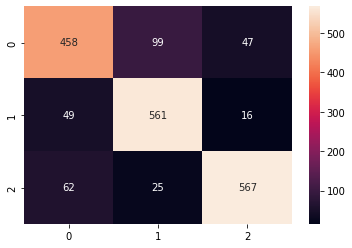

In [ ]:
prediksi2 = predictions2.select("prediction").rdd.flatMap(lambda x: x).collect()
labels2 = predictions2.select("label").rdd.flatMap(lambda x: x).collect()

# Create a confusion matrix
cm2 = confusion_matrix(labels2, prediksi2)

# Plot the confusion matrix using seaborn
sns.heatmap(cm2, annot=True, fmt=".0f")
plt.show()

In [ ]:
y_true2 = predictions2.select(['label']).collect()
y_pred2 = predictions2.select(['prediction']).collect()
print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       604
         1.0       0.82      0.90      0.86       626
         2.0       0.90      0.87      0.88       654

    accuracy                           0.84      1884
   macro avg       0.84      0.84      0.84      1884
weighted avg       0.84      0.84      0.84      1884

